# House 64613
## Tasks
<ul>
    <li> Work Out Rated Power of Hot Water [x]
    <li> Work Out how long it runs each day [x]
</ul>

### Setup libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Importing Data and cleaning up


In [2]:
house_id = 64613
df = pd.read_csv('../data/'+str(house_id)+'.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop_duplicates(keep='first', inplace=True)
df['reading_datetime'] = pd.to_datetime(df['reading_datetime'])
df.set_index('reading_datetime', inplace=True)
df.sort_index(inplace=True)
df['circuit_id_monitor'] = df.circuit_id.astype(str) + ' <<' +df.monitors+'>>'

original_set = df.reset_index()
original_set = original_set.pivot(index='reading_datetime', columns='circuit_id_monitor', values=['energy', 'energy_pos', 'energy_neg'])
net_energy = original_set[:]['energy']

print('Setup Complete')

NameError: name 'pd' is not defined

### Rated Power Calculation
The reading comes as Wh consumed in a 5 minute period <br>
It needs to be converted to Power in kW to understand the draw of appliance

$ R = E \times \frac{5}{60} \times 1000 $

The appliance is not guaranteed to start neatly at the start of each 5 minute interval.
It cannot be assumed the average rated power is the true rated power as there are significant
lower outliers to the power calculated.

Constraining the power values considered to periods where the appliance is "on" for 90% of the time
gives a better result for rated power.

"on" period is defined as:

$ on = \frac{power}{max(power)} $

In [1]:
load_type = 'hot_water'
load_investigation = net_energy.filter(regex=load_type).copy(deep=True)
load_investigation.rename(columns={load_investigation.columns[0]:'power'}, inplace=True)
load_investigation = (load_investigation * 12) / 1000
rated_power = load_investigation.power.max()
load_investigation['on_time'] = (load_investigation.power / rated_power)

on = load_investigation.loc[load_investigation.power > 0.1]
fig, ax = plt.subplots(nrows=1, ncols=2)
on.power.plot.hist(title='All Non Zero Power Values', ax=ax[0], bins=20)
period = 0.9
on = load_investigation.loc[load_investigation.on_time > period]
on.power.plot.box(title='Power Values for On Periods < ' + str(period), ax=ax[1])
plt.show()
rated_power = on.power.median()
load_investigation['on_time'] = (load_investigation.power / rated_power) * 5
print('Rated Power: ' + "{:.2f}".format(rated_power) + 'kW')


NameError: name 'net_energy' is not defined

### Duration Calculation

For each Day the total period the load was on was extracted. 

Presented below is the average duration the load was on for and also the day it was on for the longest period.

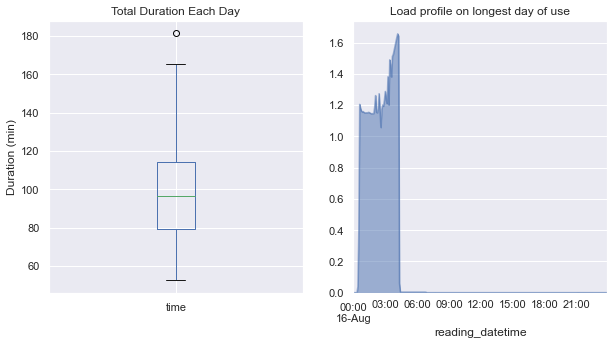

Duration Average: 1.63h


In [22]:
load_24h = load_investigation[['power', 'on_time']].copy(deep=True)
load_24h['time'] = load_24h.on_time
load_24h = load_24h.resample('24h', offset=12).sum()
non_zero_days = load_24h[load_24h.time > 20].time
longest_day = load_24h.time.idxmax()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
load_investigation[str(longest_day.date())].power.clip(lower=0).plot.area(title='Load profile on longest day of use',ax=ax[1], alpha=0.5)
non_zero_days.plot.box(title='Total Duration Each Day', ax=ax[0])
ax[0].set_ylabel('Duration (min)')
plt.show()

average_duration = non_zero_days.mean()

print('Duration Average: ' + "{:.2f}".format((average_duration / 60)) + 'h')


### Analysing the Total Consumption over the Year

#### Step 1. Get the load on its own

In [64]:
#get load by itself
load = net_energy.filter(regex=load_type).sum(axis=1)

#### Step 2. Get the net of PV and AC summed over all the monitors
The total household consumption can be preliminarily calculated as the sum of the total AC net and PV net, cancelling out the energy generated by the PV

In [35]:
#Total Rooftop Generation
pv_net = net_energy.filter(regex='pv_site_net')['energy'].sum(axis=1)
ac_net = net_energy.filter(regex='ac_load_net')['energy'].sum(axis=1)
house_consumption = ac_net + pv_net


#### Step 3. Work out whether the Load is included in the AC Net
This is done by taking the differential of both the load and the AC Net and checking how well the changes in load and AC net align. 

If the spikes in Load and AC net align greater than 95% of the time the load can be assumed to be in the AC net. 

This means we can find the true consumption for the house by either including or not including the load to the AC net.

The total import and export energy can also be found and the household consumption without the load. 

In [36]:
# removes the PV component to expose 
house_consumption_diff = house_consumption.diff()
load_diff = load.diff()
house_spikes = (house_consumption_diff.abs() > house_consumption_diff.std())
load_spikes = (load_diff.abs() > load_diff.std())
aligned = load_spikes & house_spikes


if aligned.sum() / load_spikes.sum() > 0.05:
    house_consumption = house_consumption
    grid_import = ac_net.clip(lower=0)
    grid_export = (ac_net * - 1).clip(lower=0)
    
    
else:
    house_consumption = house_consumption + load
    grid_import = (ac_net + load).clip(lower=0)
    grid_export = ((ac_net + load)* - 1).clip(lower=0)

house_consumption_without_load = house_consumption - load


#### Step 4. Calculate the total PV utilisation
PV utilisation is the amount of PV generation that is used within the home.

This is calculated as the lower of the generation or the household consumption when the PV are generating.

$ PV utilisation = min(PV_gen, household_consumption) $


In [62]:
# floored at zero to make plots nicer
pv_utilisation = pd.concat([pv_net, house_consumption], axis=1).min(axis=1).clip(lower=0)

### Conclusion
The total consumption and the import and export are listed below

The house PV utilisation is included as well

The day the house used the load the longest is presented as a chart to illustrate the information extracted

House Usage Total		6245.26kWh
Import total			3998.13kWh
Export total			3113.42kWh

PV total			5360.55kWh
PV self consumed total		2251.30kWh
PV exported			3109.25kWh
PV utilisation			42.00%


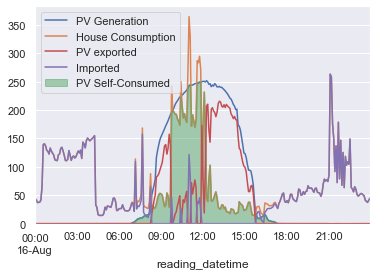

In [61]:
house_consumption_total = house_consumption.sum() / 1000
pv_gen_total = pv_net.sum() / 1000
grid_import_total = grid_import.sum() / 1000
grid_export_total = grid_export.sum() / 1000
pv_utilisation_total = pv_utilisation.sum() /1000

export = pv_net - pv_utilisation
export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")

pv_net[str(longest_day.date())].plot(label='PV Generation')
house_consumption[str(longest_day.date())].plot(label='House Consumption')
pv_utilisation[str(longest_day.date())].clip(lower=0).plot.area(alpha=0.5, label='PV Self-Consumed')
export[str(longest_day.date())].plot(label='PV exported')
# grid_export[str(longest_day.date())].plot(label='Exported')
grid_import[str(longest_day.date())].plot(label='Imported')
plt.legend()
plt.show()

### Calculated how much of the load is serviced by PV after servicing all other loads in the house



In [65]:
house_consumption_when_loadon_pvgen = pd.Series(index=p.index, dtype='float64')
house_consumption_when_loadon_pvgen = np.where(((pv_net > 1) & (load > 10)), pv_utilisation, 0)
load_serviced_by_PV = (house_consumption_when_loadon_pvgen - house_consumption_without_load).clip(lower=0)

print("load total " + "{:.2f}".format(load.sum() / 1000) + "kWh")
print("load serviced by PV Total " + "{:.2f}".format(load_serviced_by_PV.sum() / 1000) + "kWh")

load total 948.09kWh
load serviced by PV Total 0.00kWh


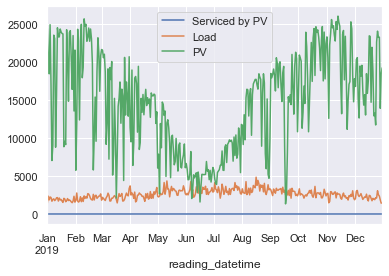

In [53]:
load_serviced_by_PV_24h = load_serviced_by_PV.resample('24h').sum()
load_24h = load.resample('24h').sum()
pv_24h = pv_net.resample('24h').sum()

load_serviced_by_PV_24h.plot(label='Serviced by PV')
load_24h.plot(label='Load')
pv_24h.plot(label='PV')
plt.legend()
plt.show()

In [54]:
def generate_load(index, start_time):
    duration = pd.Timedelta(value=average_duration,unit='m')
    y = pd.Series(np.zeros(len(pv_day)), index = index)
    start_time = pd.Timestamp(index[0]) + pd.Timedelta(value=start_time, unit='h')
    end_time = start_time + duration
    y[start_time:end_time] = (rated_power / 12) * 1000
    return y

def extract_load(load, start_time):
    pass

new_pv_utilisation = pd.Series(dtype='float64')
new_load = pd.Series(dtype='float64')
days_in_set = net_energy.index.date
days_in_set = np.unique(days_in_set)
for day in days_in_set:
    date = str(day)
#     print(date)
    con = house_consumption_without_load[date] 
    pv_day = pv_net[date]
    max_pv_util = pd.Series(dtype='float64')
    max_time = 0
    for i in range(int((24 * 60) / 5)):
        index = con.index
        load = generate_load(index, i)
        con_load = con + load
        pv_util = pd.concat([pv_day, con_load], axis=1).min(axis=1).clip(lower=0)
#         pv_util.rename('pv_util')
        if pv_util.sum() > max_pv_util.sum(): 
            max_pv_util = pv_util
            max_load = load
            max_time = i
    new_pv_utilisation = new_pv_utilisation.append(max_pv_util)
    new_load = new_load.append(max_load)

# pv_utilisation[str(days_in_set[0])].plot()
# new_pv_utilisation.plot()
# plt.show()
print('done')

done


In [66]:
house_consumption_when_loadon_pvgen = pd.DataFrame(index=pv_net.index)
house_consumption_when_loadon_pvgen['power'] = np.where(((pv_net > 1) & (new_load > 10)), new_pv_utilisation, 0)
house_consumption_when_loadon_pvgen=house_consumption_when_loadon_pvgen.power
load_serviced_by_PV = (house_consumption_when_loadon_pvgen - house_consumption_without_load).clip(lower=0)

# fig, ax = plt.subplots()
# pv_df.plot(ax=ax, label='Generation')
# house_consumption_when_loadon_pvgen.plot.area(ax=ax, label='')
# new_load.plot(ax=ax)
# load_serviced_by_PV.plot.area(ax=ax)
# plt.show()

print("load total " + "{:.2f}".format(new_load.sum() / 1000) + "kWh")
print("load serviced by PV Total " + "{:.2f}".format(load_serviced_by_PV.sum() / 1000) + "kWh")

load total 969.03kWh
load serviced by PV Total 763.77kWh


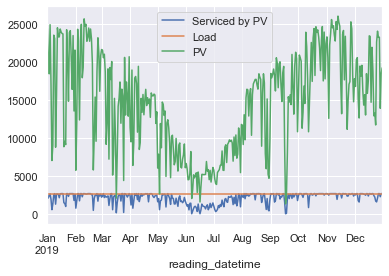

In [18]:
load_serviced_by_PV_24h = load_serviced_by_PV.resample('24h').sum()
load_24h = new_load.resample('24h').sum()
pv_24h = pv_net.resample('24h').sum()

load_serviced_by_PV_24h.plot(label='Serviced by PV')
load_24h.plot(label='Load')
pv_24h.plot(label='PV')
plt.legend()
plt.show()